# ADA 2018 - Homework 3



## Undestanding the StackOverflow community


__Deadline: Nov 7th 2018, 23:59:59__

__Submission link: Check channel homework-3-public__

__StackOverflow is the most popular programming-related Q&A website. It serves as a platform for users to ask and answer questions and to vote questions and answers up or down. Users of StackOverflow can earn reputation points and "badges"; for example, a person is awarded 10 reputation points for receiving an "up" vote on an answer given to a question, and 5 points for the "up" vote on a question asked. Also, users receive badges for their valued contributions, which represents a kind of gamification of the traditional Q&A site.__

[Learn more about StackOverflow on Wikipedia](https://en.wikipedia.org/wiki/Stack_Overflow)

----

__Dataset link:__

https://drive.google.com/open?id=1POlGjqzw9v_pZ_bUnXGihOgk45kbvNjB

http://iccluster053.iccluster.epfl.ch/Posts.json.zip (mirror 1)

https://iloveadatas.com/datasets/Posts.json.zip (mirror 2)

__Dataset description:__

* **Id**: Id of the post
* **CreationDate**: Creation date of the post (String format)
* **PostTypeId**: Type of post (Question = 1, Answer = 2)
* **ParentId**: The id of the question. Only present if PostTypeId = 2
* **Score**: Points assigned by the users
* **Tags**: Tags of the question. Only present if PostTypeId = 1
* **Title**: Only present if PostTypeId = 1
* **ViewCount**: Only present if PostTypeId = 1

__The dataset format is JSON. Here are examples of a question and an answer:__

__Question:__
```json
{
    "Id": 10130734,
    "CreationDate": "2012-04-12T19:51:25.793+02:00",
    "PostTypeId": 1,
    "Score": 4,
    "Tags": "<python><pandas>",
    "Title": "Best way to insert a new value",
    "ViewCount": 3803
}
```

__Answer:__
```json
{  
   "CreationDate":"2010-10-26T03:19:05.063+02:00",
   "Id":4020440,
   "ParentId":4020214,
   "PostTypeId":2,
   "Score":1
}
```

----
__Useful resources:__

**Spark SQL, DataFrames and Datasets Guide**

https://spark.apache.org/docs/latest/sql-programming-guide.html

**Database schema documentation for the public data dump**

https://meta.stackexchange.com/questions/2677/database-schema-documentation-for-the-public-data-dump-and-sede

**Note:** Use Spark where possible. Some computations can take more than 10 minutes on a common notebook. Consider to save partial results on disk.

----

In [107]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import calendar
%matplotlib inline

import findspark
#findspark.init(r'C:\Users\jorge\Anaconda3\pkgs\pyspark-2.3.1-py36_1001\Lib\site-packages\pyspark')
findspark.init()
findspark.find()

from datetime import datetime
from matplotlib import pyplot as plt
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.functions import min

from pyspark.sql import SparkSession
from pyspark import SparkContext

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [2]:
DATA_DIR = 'data/'

### Task A: Convert the dataset to a more convenient format
__As a warm-up task (and to avoid to warm up your laptop too much), load the dataset into a Spark dataframe, show the content, and save it in the _Parquet_ format. Use this step to convert the fields to a more convenient form.__

__Answer the following questions:__

1. __How many questions have been asked on StackOverflow?__
2. __How many answers have been given?__
3. __What is the percentage of questions with a score of 0?__

__Hint:__ The next tasks involve a time difference. Consider storing time in numeric format.

### Loading phase

First load the data from the JSON file into a Spark dataframe

In [43]:
posts = spark.read.load(DATA_DIR+'Posts.json', format="json")

Save and reload the dataframe using the parquet format

In [44]:
posts.write.mode('overwrite').parquet(DATA_DIR + 'posts-parquet')
posts = spark.read.parquet(DATA_DIR + 'posts-parquet')

In [45]:
print('There are ' + str(posts.count()) + ' entries (Q + A)')
posts.show(3)

There are 40839832 entries (Q + A)
+--------------------+--------+--------+----------+-----+--------------------+--------------------+---------+
|        CreationDate|      Id|ParentId|PostTypeId|Score|                Tags|               Title|ViewCount|
+--------------------+--------+--------+----------+-----+--------------------+--------------------+---------+
|2017-08-17T16:20:...|45740344|45740224|         2|    0|                null|                null|     null|
|2017-08-17T16:20:...|45740346|45739185|         2|    1|                null|                null|     null|
|2017-08-17T16:20:...|45740348|    null|         1|    2|<flash><react-nat...|Is it possible to...|      143|
+--------------------+--------+--------+----------+-----+--------------------+--------------------+---------+
only showing top 3 rows



The ```show``` command outputs a nice grid outline, while the ```take``` command gives us the raw rows:

In [46]:
posts.take(3)

[Row(CreationDate='2017-08-17T16:20:17.180+02:00', Id=45740344, ParentId=45740224, PostTypeId=2, Score=0, Tags=None, Title=None, ViewCount=None),
 Row(CreationDate='2017-08-17T16:20:25.720+02:00', Id=45740346, ParentId=45739185, PostTypeId=2, Score=1, Tags=None, Title=None, ViewCount=None),
 Row(CreationDate='2017-08-17T16:20:28.873+02:00', Id=45740348, ParentId=None, PostTypeId=1, Score=2, Tags='<flash><react-native>', Title='Is it possible to embed Adobe flash into a react-native app?', ViewCount=143)]

Finally, register the dataframe as a table to enable SQL querying. This will make part A very easy and manageable

In [48]:
posts.registerTempTable('posts')

### Qeurying phase

__1. How many questions have been asked on StackOverflow?__

Recall: **PostTypeId**: Type of post (Question = 1, Answer = 2)

In [49]:
query1 = """
select count(*)
from posts
where PostTypeId = 1
"""
result1 = spark.sql(query1)
result1 = result1.select(col("count(1)").alias("total_questions"))
result1.show()

+---------------+
|total_questions|
+---------------+
|       15647060|
+---------------+



__2. How many answers have been given?__

Recall: **PostTypeId**: Type of post (Question = 1, Answer = 2)

In [57]:
query2 = """
select count(*)
from posts
where PostTypeId = 2
"""
result2 = spark.sql(query2)
result2 = result2.select(col("count(1)").alias("total_answers"))
result2.show()

+-------------+
|total_answers|
+-------------+
|     25192772|
+-------------+



__3. What is the percentage of questions with a score of 0?__

In [53]:
query31="""
select count(*)
from posts
where PostTypeId = 2 and Score = 0
"""
result31 = spark.sql(query31)
result31 = result31.select(col("count(1)").alias("questions_scored_0"))
result31.show()

+------------------+
|questions_scored_0|
+------------------+
|           9833069|
+------------------+



In [55]:
q_scored0 = result31.collect()[0].questions_scored_0
total_questions = result1.collect()[0].total_questions 
percentage_scored0 = q_scored0/total_questions * 100
percentage_scored0

62.842917455419744

**Hint:** Load the dataset from the Parquet file for the next tasks.

### Task B: What are the 10 most popular tags?

__What are the most popular tags in StackOverflow? Use Spark to extract the information you need, and answer the following questions with Pandas and Matplotlib (or Seaborn):__

1. __What is the proportion of tags that appear in fewer than 100 questions?__
2. __Plot the distribution of the tag counts using an appropriate representation.__
3. __Plot a bar chart with the number of questions for the 10 most popular tags.__

__For each task describe your findings briefly.__

__1. What is the proportion of tags that appear in fewer than 100 questions?__

Again, we will use SQL to speed up our querying

First, we separate the string in the "Tags" column that includes all of the tags into an array with the tags

In [61]:
# Tags column, from string to array
postsb = posts.withColumn("Tags", split(posts["Tags"],"><").cast("array<String>"))
postsb.show(2)

+--------------------+--------+--------+----------+-----+----+-----+---------+
|        CreationDate|      Id|ParentId|PostTypeId|Score|Tags|Title|ViewCount|
+--------------------+--------+--------+----------+-----+----+-----+---------+
|2017-08-17T16:20:...|45740344|45740224|         2|    0|null| null|     null|
|2017-08-17T16:20:...|45740346|45739185|         2|    1|null| null|     null|
+--------------------+--------+--------+----------+-----+----+-----+---------+
only showing top 2 rows



Then, we can extend the table using explode in these arrays, creating rows for every array position (for every tag of each post).

In [62]:
postsb = postsb.withColumn("Tags",  explode("Tags")) #Explode the table in order to have one row for every tag in each post
charReplace = udf(lambda x: x.replace("<" ,'').replace(">", '')) #For deleting "<" and ">" in the tag names
postsb = postsb.withColumn('Tags',charReplace('Tags'))
postsb.show(2)

+--------------------+--------+--------+----------+-----+------------+--------------------+---------+
|        CreationDate|      Id|ParentId|PostTypeId|Score|        Tags|               Title|ViewCount|
+--------------------+--------+--------+----------+-----+------------+--------------------+---------+
|2017-08-17T16:20:...|45740348|    null|         1|    2|       flash|Is it possible to...|      143|
|2017-08-17T16:20:...|45740348|    null|         1|    2|react-native|Is it possible to...|      143|
+--------------------+--------+--------+----------+-----+------------+--------------------+---------+
only showing top 2 rows



Finally, we just have to count how many rows there are grouping by category (we count the total number and the tags which appear less than 100 times). We also have to consider that we are asked about the proportion of questions (not answers, PostTypeId=1).

In [63]:
queryb11="""
select Tags, count(*) as appearances
from postsb
where PostTypeId = 1
group by Tags
"""
resultb11 = spark.sql(queryb11)
#resultb11.show(3)
total_tags = resultb11.count()
total_tags

52994

In [64]:
#Number of tags which appear less than 100 times
resultb12 = resultb11.filter('appearances < 100')   #We take advantage of the last query
#resultb12.show(3)
tags_less_100=resultb12.count()
tags_less_100

36025

In [65]:
proportion = tags_less_100/total_tags
proportion

0.6797939389364833

__2. Plot the distribution of the tag counts using an appropriate representation.__

We use a pandas dataframe here for comfort

In [66]:
tag_counts_pd = resultb11.toPandas()
tag_counts_pd.head(4)

Tags  appearances
0  response.write          137
1          iframe        26125
2           input        22045
3       arguments         7157

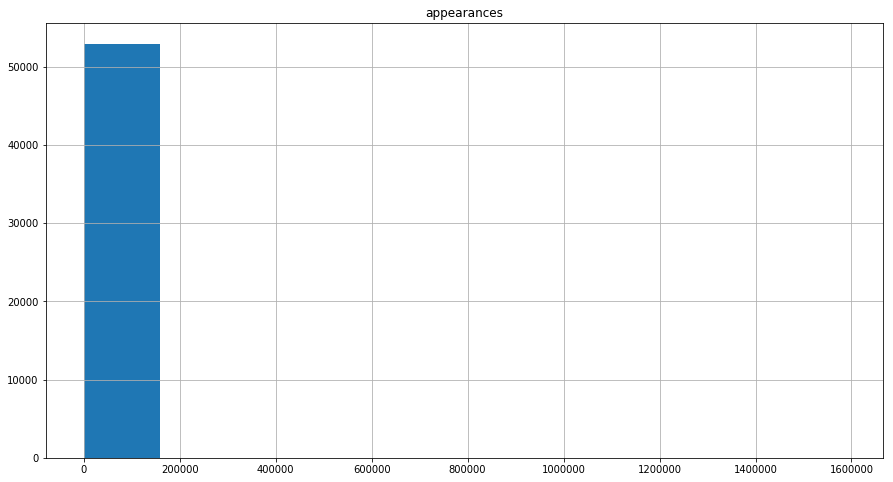

In [67]:
tag_counts_pd.hist(figsize=(15,8));

As we can see, there are some outliers. Most of the tags have less than 200000 questions (which is still a lot). In the next question we look a those very popular outliers

**3. Plot a bar chart with the number of questions for the 10 most popular tags.**

First, we compute the data frame with the 10 most popular tags (and their appearances in questions):

In [68]:
df_tmp=tag_counts_pd.set_index("Tags").sort_values(by="appearances", ascending=False).head(10)
df_tmp

appearances
Tags                   
javascript      1585495
java            1352735
c#              1172492
php             1136082
android         1088811
python           954401
jquery           886982
html             725289
ios              551843
c++              536267

With this data frame, plotting the bar chart is trivial:

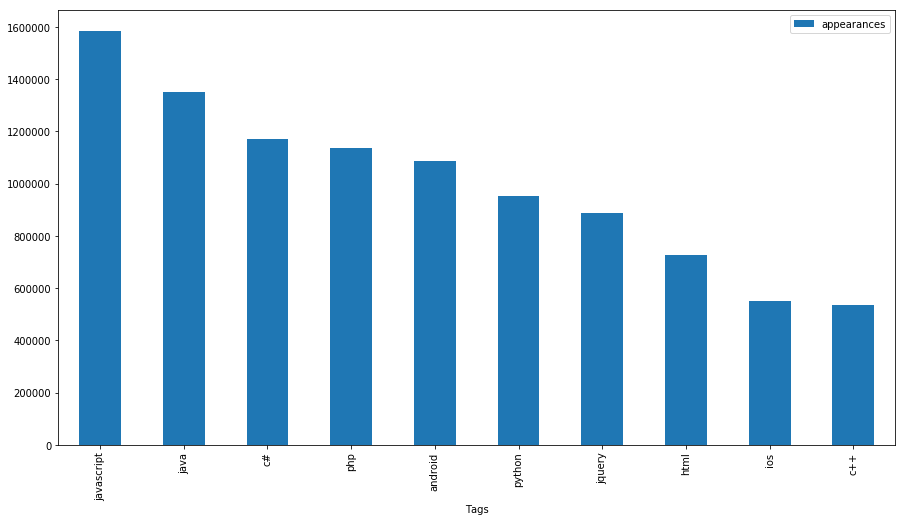

In [69]:
df_tmp.plot.bar(figsize=(15,8))

### Task C: View-score relation

__We want to investigate the correlation between the view count and the score of questions.__

1. __Get the view count and score of the questions with tag ```random-effects``` and visualize the relation between these two variables using an appropriate plot.__
2. __Are these two variables correlated? Use the Pearson coefficient to validate your hypothesis. Discuss your findings in detail.__

__Hint:__ Inspect the data visually before drawing your conclusions.

__1. Get the view count and score of the questions with tag random-effects and visualize the relation between these two variables using an appropriate plot.__

First we obtain a table with the view counts and score of the questions with tag *random-effects*. We have done it by SQL and by the table "postsb" obtained in task B.

(In this table we already have the tag vectors exploded)

In [70]:
queryc1 = """
select ViewCount, Score
from postsb
where Tags = "random-effects" and PostTypeId=1
"""
resultc1 = spark.sql(queryc1)
resultc1.show(4)

+---------+-----+
|ViewCount|Score|
+---------+-----+
|     5345|   -2|
|      852|    4|
|    42678|   25|
|      275|    0|
+---------+-----+
only showing top 4 rows



With this table is easy to get a visualization between both variables (considering just in questions with the asked tag). Note that we have done it by transforming the table to a pandas data frame and using the seaborn library:

C:\ProgramData\Anaconda3\lib\socket.py:647: ResourceWarning: unclosed <socket.socket fd=2508, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 65053), raddr=('127.0.0.1', 65052)>
  self._sock = None
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


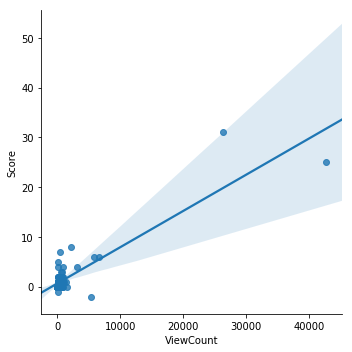

In [104]:
sns.lmplot(x='ViewCount', y='Score', data=resultc1.toPandas());

__2. Are these two variables correlated? Use the Pearson coefficient to validate your hypothesis. Discuss your findings in detail.__

We can compute the Pearson correlation coefficient directly with the last exercise result:

In [71]:
resultc1.corr("ViewCount", "Score") 

0.8821972419941506

The Pearson Correlation Coefficient (PCC) is a measure of the linear correlation between two variables X and Y. It has a value between +1 and −1, where 1 is total positive linear correlation.

In this way, it seems to make sense to obtain PCC=0.8821... because this mean that there exists a great correlation between both variables(*ViewCount* and *Score*). As you can see in the last visualization of the asked data set (*ViewCount* and *Score* of every question with *random-effects* tag) one variable usually decreases as the other variable decreases and one variable usually increases while the other increases. 

(Reminder: In statistics, a perfect positive correlation is represented by 1, while 0 indicates no correlation, and negative 1 indicates a perfect negative correlation.)


### Task D: What are the tags with the fastest first answer?

__What are the tags that have the fastest response time from the community? We define the response time as the difference in seconds between the timestamps of the question and of the first answer received.__

1. __Get the response time for the first answer of the questions with the tags ```python``` and ```java```.__
2. __Plot the two distributions in an appropriate format. What do you observe? Describe your findings and discuss the following distribution properties: mean, median, standard deviation.__
3. __We believe that the response time is lower for questions related to Python (compare to Java). Contradict or confirm this assumption by estimating the proper statistic with bootstrapping. Visualize the 95% confidence intervals with box plots and describe your findings.__
4. __Repeat the first analysis (D1) by using the proper statistic to measure the response time for the tags that appear at least 5000 times. Plot the distribution of the 10 tags with the fastest response time.__


---
### Loading phase

First we create the dataframes we are going to use, save them in parquet format and reload them

In [83]:
java_questions = postsb.filter('Tags = "java"')
java_answers = posts.filter('PostTypeId = 2').select('CreationDate',col('ParentId').alias('Id'),'PostTypeId')

java_questions.write.mode('overwrite').parquet(DATA_DIR + "java_questions.parquet")
java_answers.write.mode('overwrite').parquet(DATA_DIR + "java_answers.parquet")

In [84]:
python_questions = postsb.filter('Tags = "python"')
python_answers = posts.filter('PostTypeId = 2')

python_questions.write.mode('overwrite').parquet(DATA_DIR + "python_questions.parquet")
python_answers.write.mode('overwrite').parquet(DATA_DIR + "python_answers.parquet")

In [85]:
java_questions = spark.read.parquet(DATA_DIR + "java_questions.parquet")
java_answers = spark.read.parquet(DATA_DIR + "java_answers.parquet")

In [86]:
python_questions = spark.read.parquet(DATA_DIR + "python_questions.parquet")
python_answers = spark.read.parquet(DATA_DIR + "python_answers.parquet")

__1. Get the response time for the first answer of the questions with the tags ```python``` and ```java```.__

In order to get the difference in seconds we first need to transform the date strings into timestamps. For this we will use datetime objects, from which it is quite easy to go to timestamp.

First we format the string so it can be properly read and transformed into a datetime object.

Note that in order to join the two dataframes (questions and answers), we need them to have a common column, which is going to be the 'Id' for the questions and 'ParentId' for the answers, which we rename to 'Id', forgetting the actual 'Id' of the answer.

In [87]:
dateFormat = udf(lambda x: x[:23] + "000" + x[23:26] + x[27:])
java_answers = posts.filter('PostTypeId = 2') \
                    .select(col('CreationDate').alias('AnswerCreationDate'),col('ParentId').alias('Id')) \
                    .withColumn('AnswerCreationDate',dateFormat('AnswerCreationDate'))

We now join questions and answers

In [92]:
java_q_and_a = java_questions.join(java_answers,'Id') \
                             .select('Id', col('CreationDate').alias('QuestionCreationDate'),'AnswerCreationDate') \
                             .withColumn('QuestionCreationDate', dateFormat('QuestionCreationDate'))

In [100]:
java_q_and_a_df = java_q_and_a.toPandas()
java_q_and_a_df.head(3)

C:\ProgramData\Anaconda3\lib\socket.py:647: ResourceWarning: unclosed <socket.socket fd=2356, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 64903), raddr=('127.0.0.1', 64902)>
  self._sock = None


Id             QuestionCreationDate               AnswerCreationDate
0  30428  2008-08-27T15:21:31.830000+0200  2008-12-21T00:07:13.363000+0100
1  30428  2008-08-27T15:21:31.830000+0200  2008-10-29T17:56:04.147000+0100
2  30428  2008-08-27T15:21:31.830000+0200  2008-11-11T03:00:57.220000+0100

Transform the string with the date into a datetime object and then into its timestamp value

In [101]:
java_q_and_a_df['AnswerCreationDate'] = java_q_and_a_df['AnswerCreationDate'].apply(lambda x: datetime.strptime(x,"%Y-%m-%dT%H:%M:%S.%f%z"))
java_q_and_a_df['AnswerCreationDate'] = java_q_and_a_df['AnswerCreationDate'].apply(lambda x: calendar.timegm(x.timetuple()))
java_q_and_a_df.head(3)

Id             QuestionCreationDate  AnswerCreationDate
0  30428  2008-08-27T15:21:31.830000+0200          1229818033
1  30428  2008-08-27T15:21:31.830000+0200          1225302964
2  30428  2008-08-27T15:21:31.830000+0200          1226372457

Same for the questions

In [102]:
java_q_and_a_df['QuestionCreationDate'] = java_q_and_a_df['QuestionCreationDate'].apply(lambda x: datetime.strptime(x,"%Y-%m-%dT%H:%M:%S.%f%z"))
java_q_and_a_df['QuestionCreationDate'] = java_q_and_a_df['QuestionCreationDate'].apply(lambda x: calendar.timegm(x.timetuple()))
java_q_and_a_df.head(3)

Id  QuestionCreationDate  AnswerCreationDate
0  30428            1219850491          1229818033
1  30428            1219850491          1225302964
2  30428            1219850491          1226372457

Finally, we group all the answers with the same question and sort by answer timestamp

In [103]:
java_q_and_a_df = java_q_and_a_df.groupby(['Id', 'QuestionCreationDate']).apply(lambda x: x.sort_values(by='AnswerCreationDate', ascending=True).iloc[0])
java_q_and_a_df.head(3)

Id  QuestionCreationDate  AnswerCreationDate
Id  QuestionCreationDate                                               
123 1217606932            123            1217606932          1217608303
382 1217667507            382            1217667507          1217667528
564 1217713654            564            1217713654          1217714145

Now we repeat the whole process for the python tag

In [105]:
# filter the columns we want, format the date string
python_answers = posts.filter('PostTypeId = 2') \
                    .select(col('CreationDate') \
                    .alias('AnswerCreationDate'),col('ParentId').alias('Id')) \
                    .withColumn('AnswerCreationDate',dateFormat('AnswerCreationDate'))

# join Q&A
python_q_and_a = python_questions.join(python_answers,'Id') \
                             .select('Id', col('CreationDate').alias('QuestionCreationDate'),'AnswerCreationDate') \
                             .withColumn('QuestionCreationDate', dateFormat('QuestionCreationDate'))

# transform into pd dataframe
python_q_and_a_df = python_q_and_a.toPandas()

# get timestamp for answers
python_q_and_a_df['AnswerCreationDate'] = python_q_and_a_df['AnswerCreationDate'].apply(lambda x: datetime.strptime(x,"%Y-%m-%dT%H:%M:%S.%f%z"))
python_q_and_a_df['AnswerCreationDate'] = python_q_and_a_df['AnswerCreationDate'].apply(lambda x: calendar.timegm(x.timetuple()))

# get timestamp for answers
python_q_and_a_df['QuestionCreationDate'] = python_q_and_a_df['QuestionCreationDate'].apply(lambda x: datetime.strptime(x,"%Y-%m-%dT%H:%M:%S.%f%z"))
python_q_and_a_df['QuestionCreationDate'] = python_q_and_a_df['QuestionCreationDate'].apply(lambda x: calendar.timegm(x.timetuple()))

# group by question and sort by timestamp
python_q_and_a_df = python_q_and_a_df.groupby(['Id', 'QuestionCreationDate']).apply(lambda x: x.sort_values(by='AnswerCreationDate', ascending=True).iloc[0])
python_q_and_a_df.head(3)

C:\ProgramData\Anaconda3\lib\socket.py:647: ResourceWarning: unclosed <socket.socket fd=1124, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 65491), raddr=('127.0.0.1', 65490)>
  self._sock = None


Id  QuestionCreationDate  AnswerCreationDate
Id  QuestionCreationDate                                               
469 1217689876            469            1217689876          1217696213
502 1217696518            502            1217696518          1217702947
535 1217702634            535            1217702634          1217703416

__2. Plot the two distributions in an appropriate format. What do you observe? Describe your findings and discuss the following distribution properties: mean, median, standard deviation.__

We create a column for the response time (difference between the question timestamp and the answer timestamp)

In [108]:
java_q_and_a_df['response time'] = java_q_and_a_df['QuestionCreationDate'] - java_q_and_a_df['AnswerCreationDate']
java_plot_df = java_q_and_a_df[['Id', 'response time']].sort_values(by='response time', ascending = True)

In [109]:
java_q_and_a_df['response time'] = java_q_and_a_df['QuestionCreationDate'] - java_q_and_a_df['AnswerCreationDate']
python_q_and_a_df['response time'] = python_q_and_a_df['QuestionCreationDate'] - python_q_and_a_df['AnswerCreationDate']

java_plot_df = java_q_and_a_df[['Id', 'response time']].sort_values(by='response time', ascending = True)
python_plot_df = python_q_and_a_df[['Id', 'response time']].sort_values(by='response time', ascending = True)

In [ ]:
java_plot_df.plot(kind='bar',use_index=False);
plt.xlabel('Question ID')
plt.ylabel('Response time (seconds)')
plt.title('Response Time for Questions with the Java tag')

KeyboardInterrupt: 

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 61277)


Traceback (most recent call last):
sys:1: ResourceWarning: unclosed file <_io.BufferedWriter name=4>
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:61209)
Traceback (most recent call last):
  File "C:\Spark\spark-2.3.2-bin-hadoop2.7\python\lib\py4j-0.10.7-src.zip\py4j\java_gateway.py", line 1145, in send_command
    self.socket.sendall(command.encode("utf-8"))
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Spark\spark-2.3.2-bin-hadoop2.7\python\lib\py4j-0.10.7-src.zip\py4j\java_gateway.py", line 985, in send_command
    response = connection.send_command(command)
  File "C:\Spark\spark-2.3.2-bin-hadoop2.7\python\lib\py4j-0.10.7-src.zip\py4j\java_gateway.py", line 1149, in send_command
    "Error while sending", e, proto.ERROR_ON_SEND)
py4j.protocol.Py4JNetworkError: Erro

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:61209)
Traceback (most recent call last):
  File "C:\Spark\spark-2.3.2-bin-hadoop2.7\python\lib\py4j-0.10.7-src.zip\py4j\java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Spark\spark-2.3.2-bin-hadoop2.7\python\lib\py4j-0.10.7-src.zip\py4j\java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it--- Logging error ---
Traceback (most recent call last):
  File "C:\Spark\spark-2.3.2-bin-hadoop2.7\python\lib\py4j-0.10.7-src.zip\py4j\java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the a

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:61209)
Traceback (most recent call last):
  File "C:\Spark\spark-2.3.2-bin-hadoop2.7\python\lib\py4j-0.10.7-src.zip\py4j\java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Spark\spark-2.3.2-bin-hadoop2.7\python\lib\py4j-0.10.7-src.zip\py4j\java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it--- Logging error ---
Traceback (most recent call last):
  File "C:\Spark\spark-2.3.2-bin-hadoop2.7\python\lib\py4j-0.10.7-src.zip\py4j\java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the a

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:61209)
Traceback (most recent call last):
  File "C:\Spark\spark-2.3.2-bin-hadoop2.7\python\lib\py4j-0.10.7-src.zip\py4j\java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Spark\spark-2.3.2-bin-hadoop2.7\python\lib\py4j-0.10.7-src.zip\py4j\java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it--- Logging error ---
Traceback (most recent call last):
  File "C:\Spark\spark-2.3.2-bin-hadoop2.7\python\lib\py4j-0.10.7-src.zip\py4j\java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the a

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:61209)
Traceback (most recent call last):
  File "C:\Spark\spark-2.3.2-bin-hadoop2.7\python\lib\py4j-0.10.7-src.zip\py4j\java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Spark\spark-2.3.2-bin-hadoop2.7\python\lib\py4j-0.10.7-src.zip\py4j\java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it--- Logging error ---
Traceback (most recent call last):
  File "C:\Spark\spark-2.3.2-bin-hadoop2.7\python\lib\py4j-0.10.7-src.zip\py4j\java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the a

In [ ]:
python_plot_df.plot(kind='bar',use_index=False);
plt.xlabel('Question ID')
plt.ylabel('Response time (seconds)')
plt.title('Response Time for Questions with the Python tag')

Get some stats

In [ ]:
java_plot_df['response time'].to_frame().describe()

In [ ]:
python_plot_df['response time'].to_frame().describe()

__3. We believe that the response time is lower for questions related to Python (compare to Java). Contradict or confirm this assumption by estimating the proper statistic with bootstrapping. Visualize the 95% confidence intervals with box plots and describe your findings.__

__4. Repeat the first analysis (D1) by using the proper statistic to measure the response time for the tags that appear at least 5000 times. Plot the distribution of the 10 tags with the fastest response time.__

Due to time constraints we weren't able to finish this task :( 

### Task E: What's up with PySpark?
__The number of questions asked regarding a specific topic reflect the public’s interest on it. We are interested on the popularity of PySpark. Compute and plot the number of questions with the ```pyspark``` tag for 30-day time intervals. Do you notice any trend over time? Is there any correlation between time and number of questions?__

__1. Compute and plot the number of questions with the pyspark tag for 30-day time intervals.__

Firstly, we obtain a table with the questions (PostTypeId = 1) which have *pyspark* tag and with their creation date.

In [74]:
querye1="""
select Tags, CreationDate
from postsb
where PostTypeId = 1 and Tags = "pyspark"
"""
resulte1 = spark.sql(querye1)
resulte1.show(4)

+-------+--------------------+
|   Tags|        CreationDate|
+-------+--------------------+
|pyspark|2015-02-18T22:18:...|
|pyspark|2015-02-19T09:10:...|
|pyspark|2015-02-19T11:33:...|
|pyspark|2015-02-20T00:01:...|
+-------+--------------------+
only showing top 4 rows



We transform this table to a pandas data frame in order to work with the date data and to plot the asked distribution.

In [75]:
df_pyspark = resulte1.toPandas()

Transform from string to datetime object:

In [76]:
df_pyspark["CreationDate"] = df_pyspark["CreationDate"].apply(lambda x: x[:23] + "000" + x[23:26] + x[27:])
df_pyspark["CreationDate"] = df_pyspark["CreationDate"].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%f%z"))
df_pyspark.head(3)

Tags                      CreationDate
0  pyspark  2015-02-18 22:18:59.567000+01:00
1  pyspark  2015-02-19 09:10:54.780000+01:00
2  pyspark  2015-02-19 11:33:12.143000+01:00

Now transform from datetime to timestamp and substract the timestamp of the first entry to the whole column

In [77]:
df_pyspark2 = df_pyspark.copy()
df_pyspark2["CreationDate"] = df_pyspark2["CreationDate"].apply(lambda x: calendar.timegm(x.timetuple()))
first_time = df_pyspark2["CreationDate"].min()
df_pyspark2["CreationDate"] = df_pyspark2["CreationDate"].apply(lambda x: x-first_time)
df_pyspark2.head(3)

Tags  CreationDate
0  pyspark      26005125
1  pyspark      26044240
2  pyspark      26052778

Now, we get the 30 days intervals dividing the CreationDate column by the number of seconds in 30 days and taking the floor, giving us an integer that will represent the interval to which that row belongs

In [78]:
n_seconds_per_30_days=3600*24*30
df_pyspark2["CreationDate"]=df_pyspark2["CreationDate"].apply(lambda x: int(x/n_seconds_per_30_days))
df_pyspark2.head()

Tags  CreationDate
0  pyspark            10
1  pyspark            10
2  pyspark            10
3  pyspark            10
4  pyspark            10

Finally, we sort the data frame by the interval number and plot a histogram with the number of questions per interval.

Text(0,0.5,'Questions with pyspark tag')

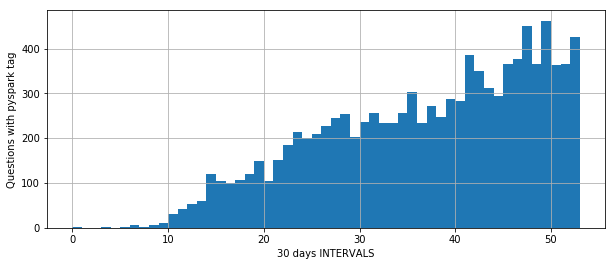

In [79]:
df_pyspark2=df_pyspark2.sort_values(by="CreationDate")
#bins=number of intervals we have consider
ax=df_pyspark2["CreationDate"].hist(bins=df_pyspark2["CreationDate"].max(), figsize=(10,4)) 
ax.set_xlabel("30 days INTERVALS")
ax.set_ylabel("Questions with pyspark tag")

__2. Do you notice any trend over time? Is there any correlation between time and number of questions?__

We can clearly see that the number of questions with the pyspark tag increases over time. This trend translates into a big correlation between both variables. To compute the correlation coefficient we first create a data frame with the data of both variables

In [80]:
df_for_correlation=df_pyspark2["CreationDate"].value_counts().to_frame()
df_for_correlation=df_for_correlation.reset_index()
df_for_correlation.columns=["30_days_interval", "Counts"]
df_for_correlation.head()

30_days_interval  Counts
0                49     462
1                47     451
2                52     403
3                41     386
4                46     377

In [81]:
df_for_correlation.corr()

30_days_interval    Counts
30_days_interval          1.000000  0.880159
Counts                    0.880159  1.000000

This correlation coefficient(0.880159) makes sense since it indicates a positive correlation between both variables (and as we have said before, one variable usually decreases as the other variable decreases and one variable usually increases while the other increases.). This confirms that pyspark is becoming more popular!